In [1]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [2]:
def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.show()

## Task 1. Hough Transform for Circles

Read the image billiards.png

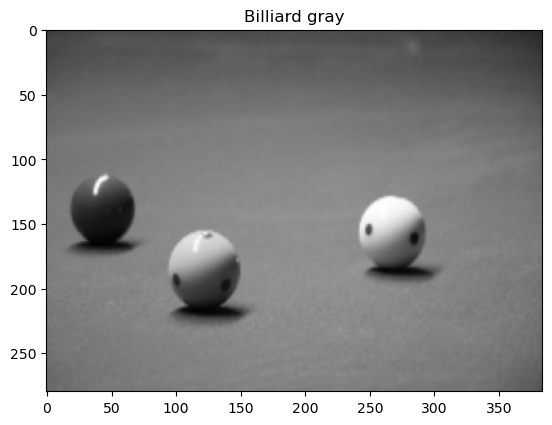

Billiard shape: (280, 384)


In [3]:
# set image path
billiards_path = './images/billiards.png'
# read imgs
img_billiards = cv.imread(billiards_path, cv.IMREAD_GRAYSCALE)

display_image('Billiard gray', img_billiards)
print(f"Billiard shape: {img_billiards.shape}")

(a) Detect the circles by a Hough transform using cv2.HoughCircles.
Visualize the detections by drawing circles on the image.

Lets use Canny Edge detector to extract the object shapes from the image

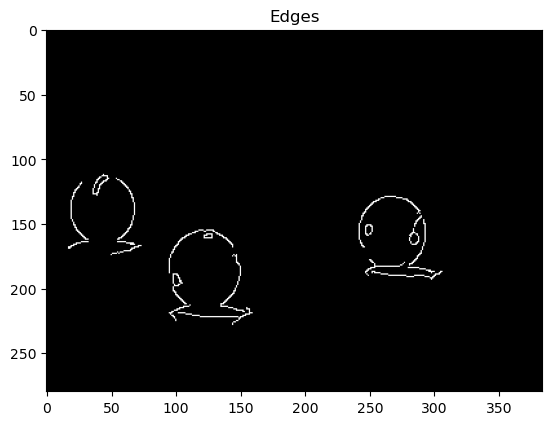

Edges shape: 0


In [4]:
img_blur = cv.GaussianBlur(img_billiards, (3, 3), 0)
edges = cv.Canny(img_blur, 75, 150).astype(np.uint8)
display_image('Edges', edges)
print(f"Edges shape: {edges.min()}")

In [5]:
# Apply Hough transform to greyscale image
circles = cv.HoughCircles(img_billiards,cv.HOUGH_GRADIENT,1,15,
                     param1=90,param2=30,minRadius=0,maxRadius=0)

circles = np.uint8(np.around(circles))

[[[ 12 156  27]
  [122 180  25]
  [ 44 140  24]]]


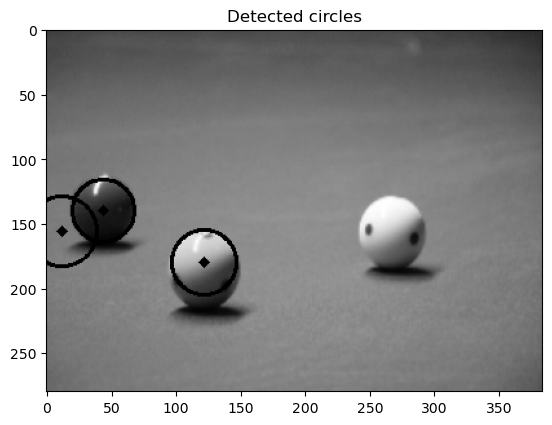

In [6]:
img_billiards_copy = img_billiards.copy()
# Draw the circles
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(img_billiards_copy,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(img_billiards_copy,(i[0],i[1]),2,(0,0,255),3)
print(circles)

display_image('Detected circles', img_billiards_copy)

(b) Implement the function myHoughCircles and use it to detect the circles.
Visualize the detections and comment on how the result varies with different
parameters.

In [7]:
def myHoughCircles(edges, minRadius, maxRadius, threshold, minDist):
    """
    Your implementation of HoughCircles
    :edges: single-channel binary source image (e.g: edges)
    :minRadius: minimum circle radius
    :maxRadius: maximum circle radius
    :param threshold: minimum number of votes to consider a detection
    :minDist: minimum distance between two centers of the detected circles. 
    :return: list of detected circles as (a, b, r) triplet
    """
    accumulator = np.zeros((edges.shape[0], edges.shape[1], maxRadius))
    detected_circles = []
    for x in range(edges.shape[0]):
        for y in range(edges.shape[1]):
            if edges[x, y] == 255:
                for r in range(minRadius, maxRadius):
                    for theta in range(0, 360):
                        a = int(x - r * np.cos(np.deg2rad(theta)))
                        b = int(y - r * np.sin(np.deg2rad(theta)))
                        if a >= 0 and a < edges.shape[0] and b >= 0 and b < edges.shape[1]:
                            accumulator[a, b, r] += 1
    for x in range(accumulator.shape[0]):
        for y in range(accumulator.shape[1]):
            for r in range(accumulator.shape[2]):
                if accumulator[x, y, r] >= threshold:
                    detected_circles.append([x, y, r])
    
    return detected_circles

In [8]:
# Apply My Hough transform to edges image
minRadius = 10
maxRadius = 100
minDist = edges.shape[0]/8
threshold = 40
my_circles = myHoughCircles(edges, minRadius=minRadius,maxRadius=maxRadius, threshold=threshold, minDist=minDist)

my_circles = np.uint8(np.around(my_circles))



KeyboardInterrupt: 

In [ ]:
print(len(my_circles))

113821


In [ ]:
img_billiards_copy = img_billiards.copy()
# Draw the circles
for i in my_circles[0,:]:
    # draw the outer circle
    cv.circle(img_billiards_copy,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(img_billiards_copy,(i[0],i[1]),2,(0,0,255),3)
print(my_circles)

display_image('Detected circles', img_billiards_copy)

## 2. Mean Shift

Read the image line.png and use the given function houghLines to get the accumulator of the detected lines in the image. Then implement the mean shift
algorithm to find the peaks in the accumulator. Visualize the accumulator and the
lines corresponding to the peaks.

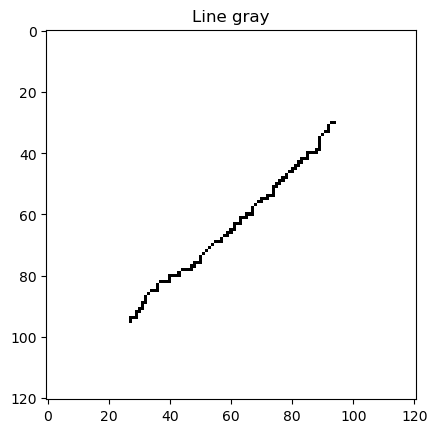

Line shape: (121, 121)


In [9]:
# set image path
line_path = './images/line.png'
# read imgs
img_line = cv.imread(line_path)
img_line_gray = cv.cvtColor(img_line, cv.COLOR_BGR2GRAY)

display_image('Line gray', img_line_gray)
print(f"Line shape: {img_line_gray.shape}")

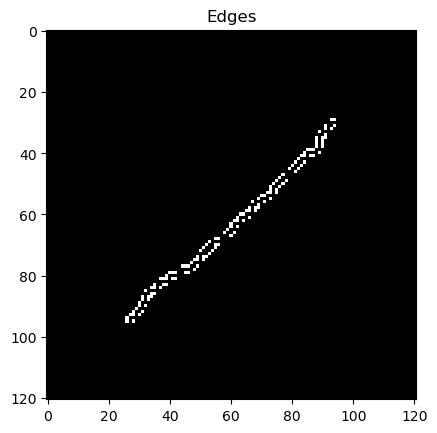

In [10]:
edges_line = cv.Canny(img_line_gray, 75, 150).astype(np.uint8)
display_image('Edges', edges_line)

In [11]:
def houghLines(img_edges, d_resolution, theta_step_sz, threshold):
    """
    Implementation of HoughLines
    :param img_edges: single-channel binary source image (e.g: edges)
    :param d_resolution: the resolution for the distance parameter
    :param theta_step_sz: the resolution for the angle parameter
    :param threshold: minimum number of votes to consider a detection
    :return: list of detected lines as (d, theta) pairs and the accumulator
    """
    accumulator = np.zeros((int(180/theta_step_sz), int(np.linalg.norm(img_edges.shape)/d_resolution)))
    edges_points = np.array(np.nonzero(img_edges))

    for i in range(edges_points.shape[1]):
        for theta in range(0, 180, theta_step_sz):
            d = int((edges_points[1][i] * np.cos(theta*np.pi/180.) + edges_points[0][i] * np.sin(theta*np.pi/180.)) / d_resolution)
            accumulator[int(theta/theta_step_sz), d] += 1
    
    accumulator_copy = accumulator
    detected_lines = []
    finished = False
    while not finished:
        idx = np.argmax(accumulator_copy)
        theta, d = np.unravel_index(idx, accumulator_copy.shape)

        if accumulator_copy[theta, d] > threshold:
            detected_lines.append([d * d_resolution, theta * theta_step_sz * np.pi / 180.])
        else:
            finished = True

        accumulator_copy[theta, d] = 0

    return detected_lines, accumulator

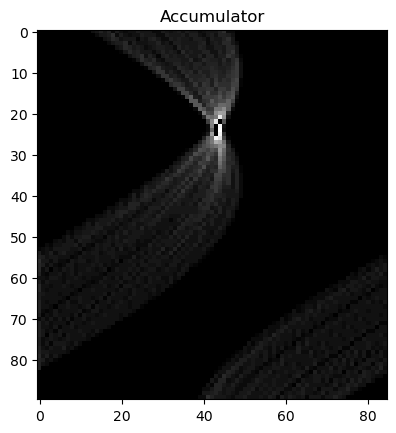

In [15]:
d_resolution = 2
theta_step_sz = 2
_, accumulator_line = houghLines(edges_line, d_resolution, theta_step_sz, 50)

display_image('Accumulator', accumulator_line)

Let's create a Normal Kernel for Kernel Density estimation

In [109]:
def get_gausian_kernel(radius):
    """
    Returns a 2D gaussian kernel
    :param radius: the radius of the kernel
    :return: 2D gaussian kernel
    """
    center = (radius, radius)
    kernel = np.zeros((2*radius+1, 2*radius+1))
    for x in range(-radius, radius+1):
        for y in range(-radius, radius+1):
            kernel[x+radius, y+radius] = np.exp(-(np.linalg.norm([x , y])**2) / (2.*radius))
    return kernel 

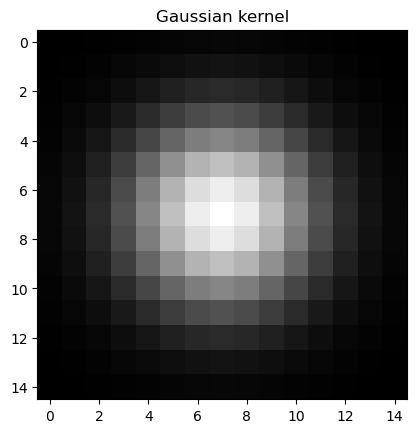

In [110]:
radius = 7
kernel = get_gausian_kernel(radius)
display_image('Gaussian kernel', kernel)

In [111]:
print(kernel.min())

0.0009118819655545162


In [105]:
def createMask(window):
    mask = np.zeros((2 * window + 1, 2 * window + 1))
    center = (window, window)
    for i in range(2 * window + 1):
        for j in range(2 * window + 1):
            if np.linalg.norm([i - center[0], j - center[1]]) < window:
                mask[i, j] = np.exp(-(np.linalg.norm([i - center[0], j - center[1]])**2) / (2.*window))
    return mask

kernel = createMask(radius)

In [112]:
def meanShift(accumulator_padded, radius, kernel, x, y):
    """
    Implementation of mean shift algorithm
    :param accumulator_padded: the accumulator with padding
    :param radius: the radius of the kernel
    :param kernel: the kernel
    :param x: the x coordinate of the peak
    :param y: the y coordinate of the peak
    :return: the new peak coordinates
    """
   

    converge = False
    i = 0
    while not converge and i < 100:
        i += 1
        sum_weighted = np.sum(kernel * accumulator_padded[y-radius:y+radius+1, x-radius:x+radius+1])
        sum_x = np.sum(np.arange(x-radius, x+radius+1) * accumulator_padded[y-radius:y+radius+1, x-radius:x+radius+1] * kernel)
        sum_y = np.sum(np.arange(y-radius, y+radius+1) * accumulator_padded[y-radius:y+radius+1, x-radius:x+radius+1] * kernel.T)
        new_x = int(np.round(sum_x / sum_weighted))
        new_y = int(np.round(sum_y / sum_weighted))
        if (new_x == x and new_y == y):
            converge = True
        x = new_x
        y = new_y
    return x, y, sum_weighted

In [113]:
def peaks2lines(peaks, d_resolution, theta_step_sz):
    """
    Converts the peaks to lines
    :param peaks: the peaks
    :param d_resolution: the d resolution
    :param theta_step_sz: the theta step size
    :return: array of lines as 4d array of the form [x1, y1, x2, y2]
    """
    lines = []
    for peak in peaks:
        d = peak[0] * d_resolution
        theta = peak[1] * theta_step_sz * np.pi / 180.
        x1 = 0
        y1 = int(d / np.sin(theta))
        x2 = int(d / np.cos(theta))
        y2 = 0
        lines.append([x1, y1, x2, y2])
    return lines

Found 2 peaks
Peaks: [[44, 24], [44, 23]]
Found lines: [[0, 118, 131, 0], [0, 122, 126, 0]]


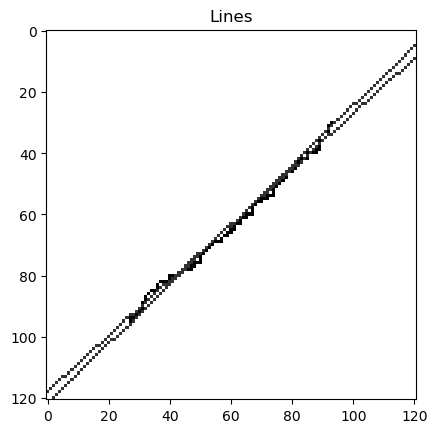

In [123]:
threshold = 415
peaks = []

accumulator_padded = accumulator_line.copy()
# add padding to the accumulator = radius to avoid out of bounds
accumulator_padded = np.pad(accumulator_padded, radius, 'constant', constant_values=0)

acc_votes_y, acc_votes_x = np.nonzero(accumulator_padded)
for idx in range(0, len(acc_votes_y), radius):
    y1 = acc_votes_y[idx]
    x1 = acc_votes_x[idx]
    
    try:
        x2, y2, sum_weighted = meanShift(accumulator_padded, radius, kernel, x1, y1)
    except:
        break

    if sum_weighted > threshold:
        x2 = int(round(x2))
        y2 = int(round(y2))
        if [x2, y2] not in peaks:
            peaks.append([x2, y2])

pruned_peaks = []
for p in peaks:
    neighbors_arr = accumulator_padded[p[1] - radius: p[1] + radius, p[0] - radius: p[0] + radius]
    y, x = np.unravel_index(np.argmax(neighbors_arr, axis=None), neighbors_arr.shape)
    if [x - 2 * radius + p[0], y - 2 * radius + p[1]] not in pruned_peaks:
        pruned_peaks.append([x - 2 * radius + p[0], y - 2 * radius + p[1]])

print(f"Found {len(pruned_peaks)} peaks")
print(f"Peaks: {pruned_peaks}")

lines = peaks2lines(pruned_peaks, d_resolution, theta_step_sz)
print(f"Found lines: {lines}")
img_line_copy = img_line.copy()
for l in lines:
    cv.line(img_line_copy, (l[0], l[1]), (l[2], l[3]), 50, 1)

display_image( "Lines", img_line_copy)